# ISR Chapter 6 - Linear Model Selection and Regularization  
from syllabus reference

- [Lab 2: Ridge Regression](#6.6.1-Ridge-Regression)
- [Lab 2: The Lasso](#6.6.2-The-Lasso)
- [Lab 3: Principal Components Regression](#6.7.1-Principal-Components-Regression)
- [Lab 3: Partial Least Squares](#6.7.2-Partial-Least-Squares)

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import glmnet as gln

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('seaborn-white')

# Ridge regression

DU

In [3]:
# In R, I exported the dataset from package 'ISLR' to a csv file.
df = pd.read_csv('Hitters datasets/Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'

df.info()
print('\n----------\n')
df.shape



<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 

(263, 20)

DU2

In [4]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


"getdummies" exploration

In [30]:
con = pd.Series(list('abchjrba'))
print(con)
print('\n----------\n')
print(pd.get_dummies(con))

0    a
1    b
2    c
3    h
4    j
5    r
6    b
7    a
dtype: object

----------

   a  b  c  h  j  r
0  1  0  0  0  0  0
1  0  1  0  0  0  0
2  0  0  1  0  0  0
3  0  0  0  1  0  0
4  0  0  0  0  1  0
5  0  0  0  0  0  1
6  0  1  0  0  0  0
7  1  0  0  0  0  0


DP1

In [5]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()

print('\n----------\n')

print(dummies.head())

print('\n----------\n')

print(dummies)

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   League_A     263 non-null    uint8
 1   League_N     263 non-null    uint8
 2   Division_E   263 non-null    uint8
 3   Division_W   263 non-null    uint8
 4   NewLeague_A  263 non-null    uint8
 5   NewLeague_N  263 non-null    uint8
dtypes: uint8(6)
memory usage: 3.6+ KB

----------

                   League_A  League_N  Division_E  Division_W  NewLeague_A  \
Player                                                                       
-Alan Ashby               0         1           0           1            0   
-Alvin Davis              1         0           0           1            1   
-Andre Dawson             0         1           1           0            0   
-Andres Galarraga         0         1           1           0            0   
-Alfredo Griffin          1         0   

DP2

In [6]:
y = df.Salary
print(y)

print('\n----------\n')

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

Player
-Alan Ashby           475.0
-Alvin Davis          480.0
-Andre Dawson         500.0
-Andres Galarraga      91.5
-Alfredo Griffin      750.0
                      ...  
-Willie McGee         700.0
-Willie Randolph      875.0
-Wayne Tolleson       385.0
-Willie Upshaw        960.0
-Willie Wilson       1000.0
Name: Salary, Length: 263, dtype: float64

----------

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  

DU3

In [7]:
X.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
Player,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
-Alvin Davis,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
-Andre Dawson,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
-Andres Galarraga,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1
-Alfredo Griffin,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1,0


DP3

In [8]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

scaledX = scale.fit_transform(X) 



### Scikit-learn


The __sklearn Ridge()__ function optimizes:
### $$ ||X\beta - y||^2_2 + \alpha ||\beta||^2_2 $$
which is equivalent to optimizing
### $$ \frac{1}{N}||X\beta - y||^2_2 + \frac{\alpha}{N} ||\beta||^2_2 $$

[5.00000000e+04 4.05565415e+04 3.28966612e+04 2.66834962e+04
 2.16438064e+04 1.75559587e+04 1.42401793e+04 1.15506485e+04
 9.36908711e+03 7.59955541e+03 6.16423370e+03 5.00000000e+03
 4.05565415e+03 3.28966612e+03 2.66834962e+03 2.16438064e+03
 1.75559587e+03 1.42401793e+03 1.15506485e+03 9.36908711e+02
 7.59955541e+02 6.16423370e+02 5.00000000e+02 4.05565415e+02
 3.28966612e+02 2.66834962e+02 2.16438064e+02 1.75559587e+02
 1.42401793e+02 1.15506485e+02 9.36908711e+01 7.59955541e+01
 6.16423370e+01 5.00000000e+01 4.05565415e+01 3.28966612e+01
 2.66834962e+01 2.16438064e+01 1.75559587e+01 1.42401793e+01
 1.15506485e+01 9.36908711e+00 7.59955541e+00 6.16423370e+00
 5.00000000e+00 4.05565415e+00 3.28966612e+00 2.66834962e+00
 2.16438064e+00 1.75559587e+00 1.42401793e+00 1.15506485e+00
 9.36908711e-01 7.59955541e-01 6.16423370e-01 5.00000000e-01
 4.05565415e-01 3.28966612e-01 2.66834962e-01 2.16438064e-01
 1.75559587e-01 1.42401793e-01 1.15506485e-01 9.36908711e-02
 7.59955541e-02 6.164233

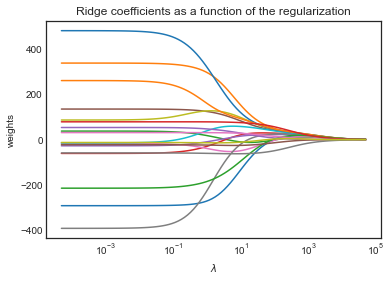

In [9]:
lambda_params = 10**np.linspace(5,-4,100)*0.5  # can't use lambda

print(lambda_params)
print('\n----------\n')

# ridge = Ridge()
coefs = []
errors_test = []



for a in lambda_params:
    ridge = Ridge(alpha=a)
    ridge.fit(scaledX, y)
    coefs.append(ridge.coef_)

    # collect error for each lambda - test data
    pred = ridge.predict(scaledX)
    temp_error = mean_squared_error(y, pred)
    errors_test.append(temp_error)


# coeffs plot
ax = plt.gca()
ax.plot(lambda_params, coefs)
ax.set_xscale('log')
# ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('$\lambda$')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');


Error plot

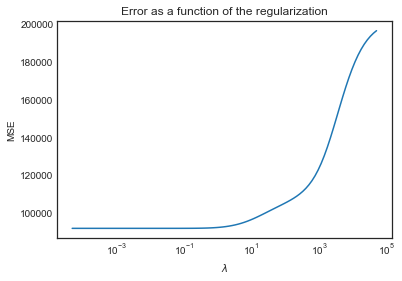

In [10]:

# error plot
ax2 = plt.gca()
ax2.plot(lambda_params, errors_test, label='test')
ax2.set_xscale('log')
# ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('$\lambda$')
plt.ylabel('MSE')
plt.title('Error as a function of the regularization');



find minimum point

Minimum error is 92017.86902087786 for lambda=5e-05

----------



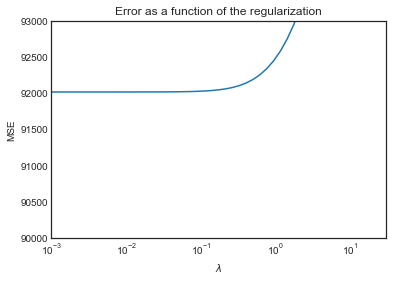

In [13]:
# error plot
ax2 = plt.gca()
ax2.plot(lambda_params, errors_test, label='test')
ax2.set_xscale('log')
ax2.set_xlim(0.001,30)

ax2.set_ylim(90000,93000)

plt.xlabel('$\lambda$')
plt.ylabel('MSE')
plt.title('Error as a function of the regularization');


# find best lambda

best_val, idx = min((val, idx) for (idx, val) in enumerate(errors_test))

print(f"Minimum error is {best_val} for lambda={lambda_params[idx]}" )

print('\n----------\n')


#### Evaluate with $\lambda$ = 5 e-05

In [14]:
ridge2 = Ridge(alpha=5*10**-5)
ridge2.fit(scaledX, y)
pred = ridge2.predict(scaledX)  
mean_squared_error(y, pred)

92017.86902087786

In [15]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat         -291.093669
Hits           337.827439
HmRun           37.852024
Runs           -60.569670
RBI            -26.993317
Walks          135.073160
Years          -16.695158
CAtBat        -391.027395
CHits           86.697398
CHmRun         -14.175202
CRuns          480.731188
CRBI           260.678194
CWalks        -213.889653
PutOuts         78.761297
Assists         53.732112
Errors         -22.161024
League_N        31.248794
Division_W     -58.414214
NewLeague_N    -12.348996
dtype: float64

#### Evaluate with $\lambda$ = $10^{10}$ 
This big penalty shrinks the coefficients to a very large degree and makes the model more biased, resulting in a higher MSE.

In [16]:
ridge2 = Ridge(alpha=10**10)
ridge2.fit(scaledX, y)
pred = ridge2.predict(scaledX)  # was X_test
mean_squared_error(y, pred)

202734.2365091716

In [17]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat          4.674815e-06
Hits           5.194717e-06
HmRun          4.062084e-06
Runs           4.971899e-06
RBI            5.322400e-06
Walks          5.256206e-06
Years          4.744517e-06
CAtBat         6.230411e-06
CHits          6.500100e-06
CHmRun         6.216145e-06
CRuns          6.663140e-06
CRBI           6.713918e-06
CWalks         5.800395e-06
PutOuts        3.558241e-06
Assists        3.012107e-07
Errors        -6.395428e-08
League_N      -1.691230e-07
Division_W    -2.279725e-06
NewLeague_N   -3.356510e-08
dtype: float64

### 6.6.2 The Lasso

### Scikit-learn



For both __glmnet__ in R and sklearn __Lasso()__ function the standard L1 penalty is:
### $$ \lambda |\beta|_1 $$

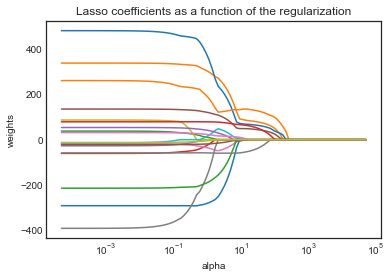

In [18]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in lambda_params:
    lasso.set_params(alpha=a)
    lasso.fit(scaledX, y)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(lambda_params, coefs)
ax.set_xscale('log')

plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

Repeat with auto-find (& cross-validation)

In [19]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000) # lambda set automatically
lassocv.fit(scaledX, y.values.ravel())

LassoCV(cv=10, max_iter=10000)

Alpha_ is the amount of penalization chosen by cross validation (lambda)

In [20]:
lassocv.alpha_

2.552820965069261

Lasso didn't do quite as well

In [21]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scaledX, y)
mean_squared_error(y, lasso.predict(scaledX))

94422.46437064184

In [22]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat         -234.400383
Hits           259.945928
HmRun            0.000000
Runs            -0.000000
RBI              0.000000
Walks          104.147836
Years          -45.975128
CAtBat          -0.000000
CHits            0.000000
CHmRun          45.048644
CRuns          223.554574
CRBI           122.906312
CWalks        -144.160342
PutOuts         76.490015
Assists         26.147094
Errors         -13.796164
League_N        16.193484
Division_W     -59.564772
NewLeague_N     -0.000000
dtype: float64

# Lab 3

### 6.7.1 Principal Components Regression

Scikit-klearn does not have an implementation of PCA and regression combined like the 'pls' package in R.
https://cran.r-project.org/web/packages/pls/vignettes/pls-manual.pdf

Transform data and perform PCA

In [47]:
from sklearn.preprocessing import StandardScaler
print(scaledX.shape)


pca = PCA()
X_reduced = pca.fit_transform(scaledX)

print(pca.components_.shape)
pd.DataFrame(pca.components_.T).loc[:4,:5]

(263, 19)
(19, 19)


,0,1,2,3,4,5
0,0.198290,-0.383784,0.088626,0.031967,0.028117,-0.070646
1,0.195861,-0.377271,0.074032,0.017982,-0.004652,-0.082240
2,0.204369,-0.237136,-0.216186,-0.235831,0.077660,-0.149646
3,0.198337,-0.377721,-0.017166,-0.049942,-0.038536,-0.136660
4,0.235174,-0.314531,-0.073085,-0.138985,0.024299,-0.111675


DU1 View transformed dataset

In [48]:
print(X_reduced.shape)
pd.DataFrame(X_reduced).loc[:4,:5]

(263, 19)


,0,1,2,3,4,5
0,-0.009649,1.870522,1.265145,-0.935481,1.109636,1.211972
1,0.411434,-2.429422,-0.909193,-0.264212,1.232031,1.826617
2,3.466822,0.825947,0.555469,-1.616726,-0.857488,-1.028712
3,-2.558317,-0.230984,0.519642,-2.176251,-0.820301,1.491696
4,1.027702,-1.573537,1.331382,3.494004,0.983427,0.513675


Evaluation of PCA

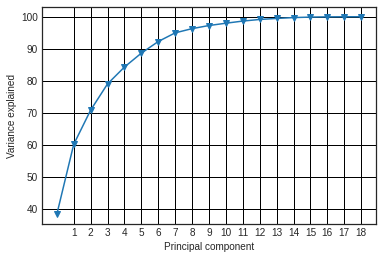

In [49]:
# Variance explained by the principal components
var_expl = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

  
plt.plot(var_expl, '-v')
plt.xlabel('Principal component')
plt.ylabel('Variance explained')

plt.xticks(range(1,19))
plt.grid(color='k', linestyle='-', linewidth=1)

Perform PCR

There are 263 datapoints


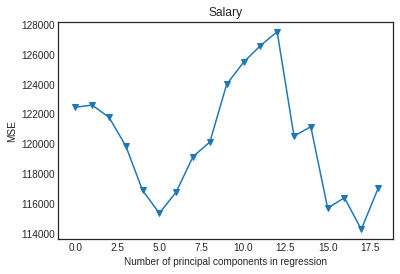

In [50]:
# 10-fold CV, with shuffle
n = len(X_reduced)
print(f"There are {n} datapoints")

kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
# mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

The above plot indicates that the lowest training MSE is reached when doing regression on 17 components.

In [51]:
regr_test = LinearRegression()
regr_test.fit(X_reduced, y)
regr_test.coef_

array([ 106.36859204,  -21.60350456,   24.2942534 ,  -36.9858579 ,
        -58.41402748,   62.20632652,   24.63862038,   15.82817701,
         29.57680773,   99.64801199,  -30.11209105,   20.99269291,
         72.40210574, -276.68551696,  -74.17098665,  422.72580227,
       -347.05662353, -561.59691587,  -83.25441536])

#### Fitting PCA with training data

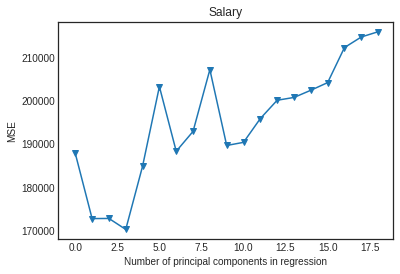

In [53]:
# load reduced datasets
X_train = pd.read_csv('Hitters_X_train.csv', index_col=0)
y_train = pd.read_csv('Hitters_y_train.csv', index_col=0)
X_test = pd.read_csv('Hitters_X_test.csv', index_col=0)
y_test = pd.read_csv('Hitters_y_test.csv', index_col=0)

pca2 = PCA()
X_reduced_train = pca2.fit_transform(X_train)
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()    
# mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced_train[:,:i], y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

The above plot indicates that the lowest training MSE is reached when doing regression on 4 components.

#### Transform test data with PCA loadings and fit regression on varied principal components

In [54]:
X_reduced_test = pca2.transform(X_test)[:,:12]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:12], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

119732.76151832349

### 6.7.2 Partial Least Squares

  
See documentation:
http://scikit-learn.org/dev/modules/generated/sklearn.cross_decomposition.PLSRegression.html#sklearn.cross_decomposition.PLSRegression

Perform a sweep of PLS and plot results

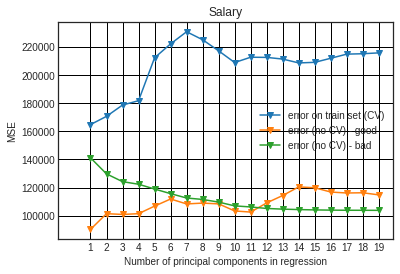

In [56]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10,  shuffle=True, random_state=1)

mse_on_train_CV = []
mse_on_test_good = []
mse_on_test_bad = []

for i in np.arange(1, 20):
    # instantiate models
    pls = PLSRegression(n_components=i)
    pls2 = PLSRegression(n_components=i)
    pls3 = PLSRegression(n_components=i)

    # use training set to train and calculate error, using cross-validation approach
    score_train_CV = cross_val_score(pls, X_train, y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse_on_train_CV.append(-score_train_CV)

    # train on training set, calc error on test set (no CV) - correct approach 2 of 2
    pls2.fit(X_train, y_train)
    mse_on_test_good.append(mean_squared_error(y_test, pls2.predict(X_test)) )

    # train on training set, calc error on train set (no CV) - bad approach
    pls3.fit(X_train, y_train)
    mse_on_test_bad.append(mean_squared_error(y_train, pls3.predict(X_train)) )


    # use test set to train and calculate error, using cross-validation approach - correct approach 1 of 2
    # score_test_CV = cross_val_score(pls, X_test, y_test, cv=kf_10, scoring='neg_mean_squared_error').mean()
    # mse_on_train.append(-score_test_CV)

    # train on test set, calc error on test set
    # pls2.fit(X_test, y_test)
    # mse_on_test.append(mean_squared_error(y_test, pls2.predict(X_test)) )


plt.plot(np.arange(1, 20), np.array(mse_on_train_CV), '-v', label='error on train set (CV)')
plt.plot(np.arange(1, 20), np.array(mse_on_test_good), '-v', label='error (no CV) - good')
plt.plot(np.arange(1, 20), np.array(mse_on_test_bad), '-v', label='error (no CV) - bad')

# annotate plot
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.legend()

#format plot
plt.xlim(xmin=-1);
plt.xticks(range(1,20))
plt.grid(color='k', linestyle='-', linewidth=1)

# change plot size
import matplotlib.pyplot as pltlib
pltlib.rcParams["figure.figsize"] = (10,8)
pltlib.rcParams['figure.dpi'] = 100

# access PLS attribute
# print(pls2.coef_)


Compare training & test sets using CV

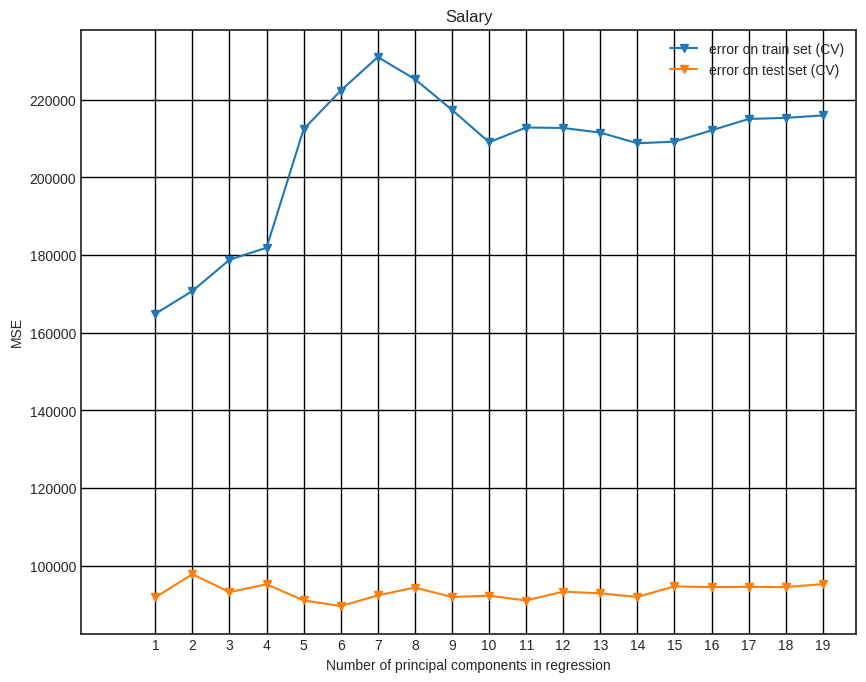

In [58]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

mse_on_train_CV = []
mse_on_test_CV = []

for i in np.arange(1, 20):
    # instantiate model
    pls = PLSRegression(n_components=i)

    # use training set to train and calculate error, using cross-validation approach
    score_train_CV = cross_val_score(pls, X_train, y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse_on_train_CV.append(-score_train_CV)

    # use training set to train and calculate error, using cross-validation approach
    score_test_CV = cross_val_score(pls, X_test, y_test, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse_on_test_CV.append(-score_test_CV)

plt.plot(np.arange(1, 20), np.array(mse_on_train_CV), '-v', label='error on train set (CV)')
plt.plot(np.arange(1, 20), np.array(mse_on_test_CV), '-v', label='error on test set (CV)')

plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);
plt.legend()

plt.xticks(range(1,20))
plt.grid(color='k', linestyle='-', linewidth=1)

In [59]:
pls = PLSRegression(n_components=2)
pls.fit(X_train, y_train)

mean_squared_error(y_test, pls.predict(X_test))

101417.46102410385